# Trajectory Optimisation

In [1]:
import numpy as np
import torch
from torchdyn.models import NeuralODE

import matplotlib.pyplot as plt
import sys
import time
sys.path.append("../../")

### Set Seed Here

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Define the Dynamic
- Then we can replace this with a NN

In [3]:
from nn import MLP

In [4]:
class CartPole(torch.nn.Module):
    def __init__(self):
        super(CartPole, self).__init__()
        self.g = 10.
        self.m = 1.
        self.l = 1.

        self._policy = MLP([5, 32, 32, 1], activation='tanh')
    
    def forward(self, y):
        f = torch.zeros_like(y)
        # Get ddth
        x, dx, th, dth = torch.split(y, [1,1,1,1], dim=1)
        cos = torch.cos(th)  # Use math for speed
        sin = torch.sin(th)
        mc = 1.0
        ml = 0.1
        l = 0.5
        fc = 0  # TODO: Hard to be model by current version, need dissipation version
        fl = 0
        g = 9.8
        
        u = self.policy(torch.tensor([x, cos, sin, dx, dth]))

        Nc = 0

        # We can just assume Nc >= 0, coz the cart is confined into y = 0
        sgn = torch.tensor([(Nc * dx >= 0)]).float()
        ddth_temp1 = (-u - ml * l * (dth ** 2) * (sin + fc * cos * sgn)) / (mc + ml)
        ddth_temp2 = ml * cos * (cos - fc * sgn) / (mc + ml)
        ddth = (g * sin + cos * (ddth_temp1 + fc * g * sgn) - (fl * dth) / (ml * l)) / (l * (4 / 3 - ddth_temp2))

        Nc = (mc + ml) * g - ml * l * (ddth * sin + dth ** 2 * cos)

        if Nc < 0:
            sgn = torch.tensor([(Nc * dx >= 0)]).float()
            ddth_temp1 = (-u - ml * l * (dth ** 2) * (sin + fc * cos * sgn)) / (mc + ml)
            ddth_temp2 = ml * cos * (cos - fc * sgn) / (mc + ml)
            ddth = (g * sin + cos * (ddth_temp1 + fc * g * sgn) - (fl * dth) / (ml * l)) / (l * (4 / 3 - ddth_temp2))

            Nc = (mc + ml) * g - ml * l * (ddth * sin + dth ** 2 * cos)

        ddx = (u + ml * l * ((dth ** 2) * sin - ddth * cos) - fc * Nc * sgn) / (mc + ml)

        f[:, 0] = dx
        f[:, 1] = ddx
        f[:, 2] = dth
        f[:, 3] = ddth
        return f
    
    def policy(self, x):
        action = self._policy(x)
        # action = torch.tanh(action)
        # action = torch.clamp(action, min=-2, max=2)
        return action

In [5]:
cartpole = CartPole()
cartpoleODE = NeuralODE(cartpole, sensitivity='adjoint', solver='rk4').to(device)

### Check the Model

In [6]:
init_state = torch.tensor([0, 0, 3 * np.pi / 4, 0]).reshape(1, -1).float()
t_span = torch.linspace(0, 5, 100)
traj = cartpoleODE.trajectory(init_state, t_span)
dummy = torch.cat([torch.cos(traj[:, 0, 0:1]), torch.sin(traj[:, 0, 0:1]), traj[:, 0, 1:]], dim=1)
actions = cartpoleODE.defunc.m.policy(dummy)
print(traj.shape)
print(actions.shape)

torch.Size([100, 1, 4])
torch.Size([100, 1])


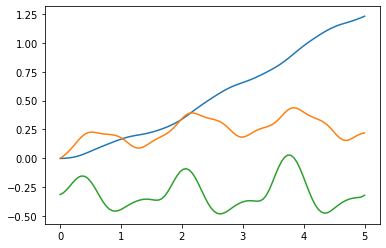

In [7]:
plt.plot(t_span.detach().numpy(), traj[:, 0, 0:2].detach().numpy())
plt.plot(t_span.detach().numpy(), actions.detach().numpy())
# plt.ylim(-2, 2)

### Optimise the control

In [8]:
import torch.optim as optim

In [9]:
optimizer = optim.Adam(cartpole.parameters(), lr=0.05)

In [10]:
traj.shape

torch.Size([100, 1, 4])

In [11]:
def total_cost(traj, actions):
    rc = 0.5 * (torch.square(1.0 - torch.cos(traj[:, 0, 2]))
                + torch.square(traj[:, 0, 1])
                + torch.square(traj[:, 0, 3]))
    costs = rc
    
    return costs.sum()

0 tensor(4841.0166, grad_fn=<SumBackward0>)


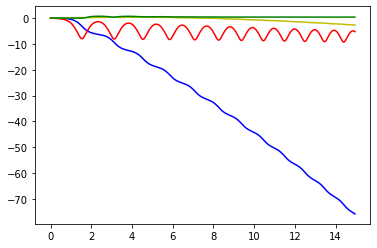

1 tensor(4386.5483, grad_fn=<SumBackward0>)


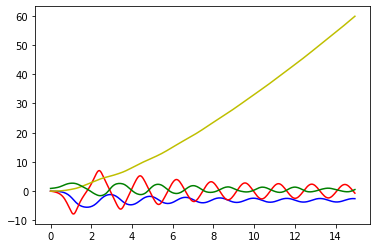

2 tensor(1291.9575, grad_fn=<SumBackward0>)


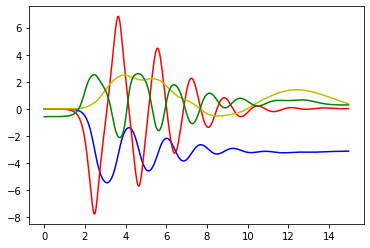

3 tensor(1427.3402, grad_fn=<SumBackward0>)


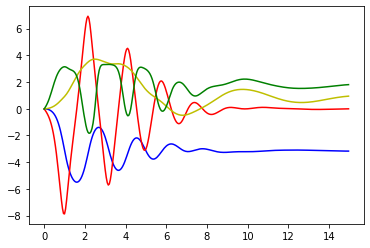

4 tensor(1440.0654, grad_fn=<SumBackward0>)


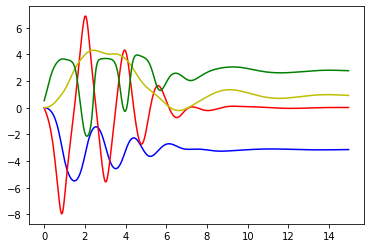

5 tensor(1443.1417, grad_fn=<SumBackward0>)


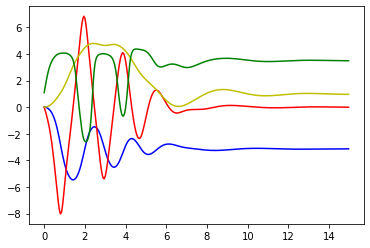

6 tensor(1450.2024, grad_fn=<SumBackward0>)


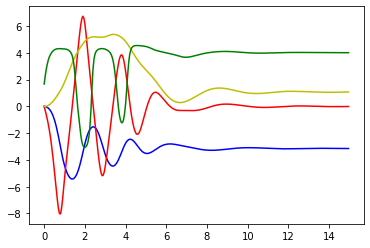

7 tensor(1461.3203, grad_fn=<SumBackward0>)


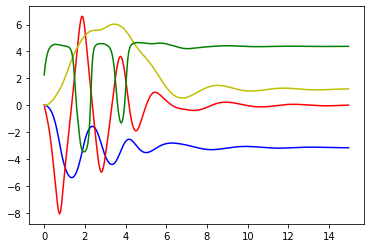

8 tensor(1471.8485, grad_fn=<SumBackward0>)


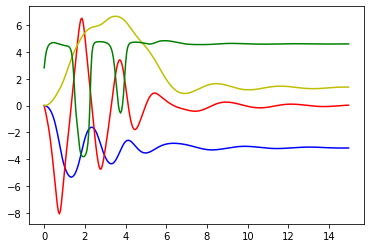

9 tensor(1476.9882, grad_fn=<SumBackward0>)


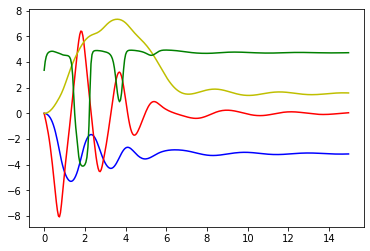

10 tensor(1477.3979, grad_fn=<SumBackward0>)


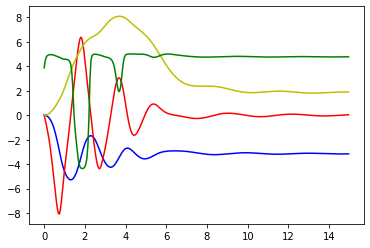

11 tensor(1482.4563, grad_fn=<SumBackward0>)


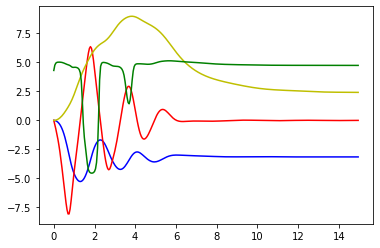

12 tensor(1502.2798, grad_fn=<SumBackward0>)


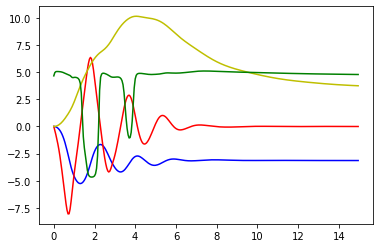

13 tensor(1545.4623, grad_fn=<SumBackward0>)


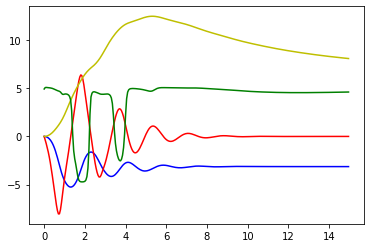

14 tensor(1739.1210, grad_fn=<SumBackward0>)


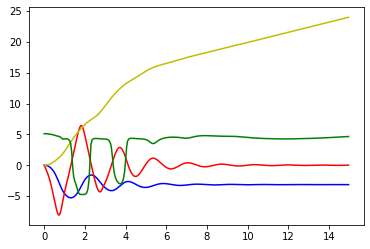

15 tensor(1610.7003, grad_fn=<SumBackward0>)


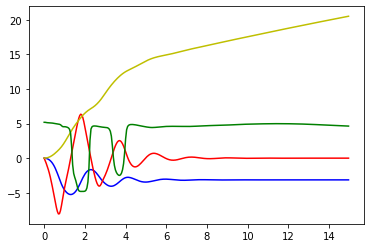

16 tensor(1401.9082, grad_fn=<SumBackward0>)


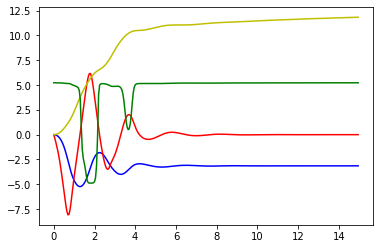

17 tensor(1329.5726, grad_fn=<SumBackward0>)


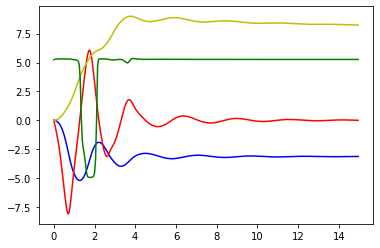

18 tensor(1312.1461, grad_fn=<SumBackward0>)


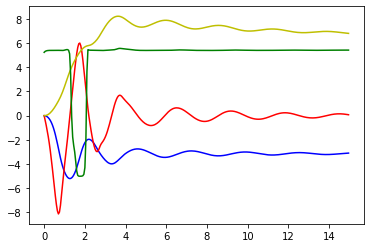

19 tensor(1315.9878, grad_fn=<SumBackward0>)


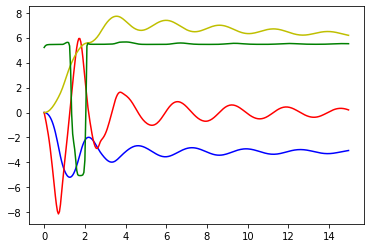

20 tensor(1323.8983, grad_fn=<SumBackward0>)


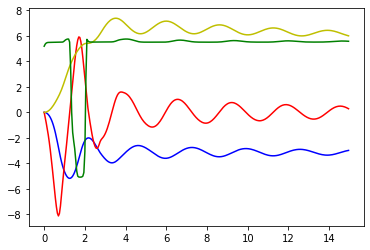

21 tensor(1325.5878, grad_fn=<SumBackward0>)


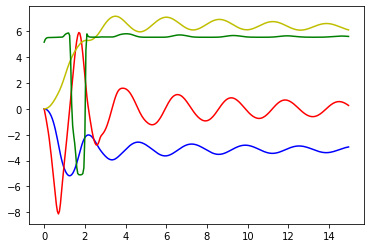

22 tensor(1318.7660, grad_fn=<SumBackward0>)


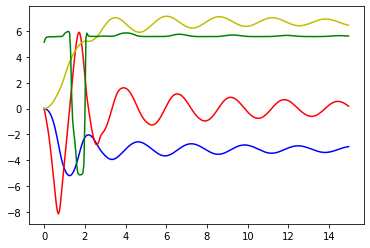

23 tensor(1306.0498, grad_fn=<SumBackward0>)


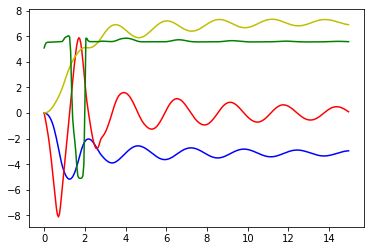

24 tensor(1291.4517, grad_fn=<SumBackward0>)


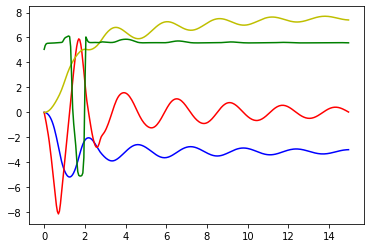

25 tensor(1277.6337, grad_fn=<SumBackward0>)


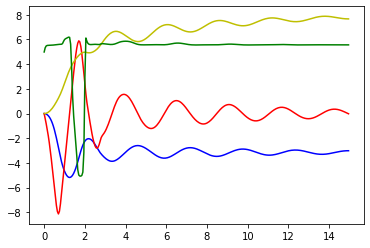

26 tensor(1265.1173, grad_fn=<SumBackward0>)


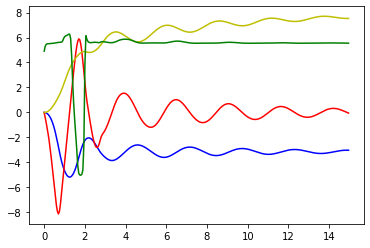

27 tensor(1253.7655, grad_fn=<SumBackward0>)


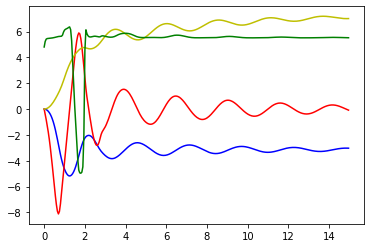

28 tensor(1243.5347, grad_fn=<SumBackward0>)


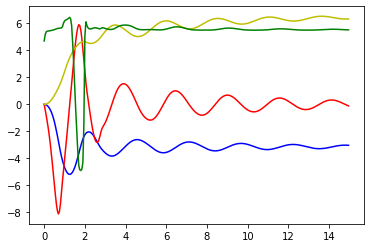

29 tensor(1234.0670, grad_fn=<SumBackward0>)


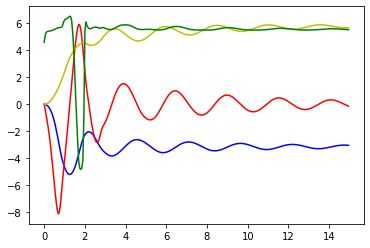

30 tensor(1224.8448, grad_fn=<SumBackward0>)


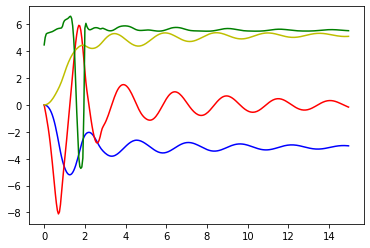

31 tensor(1215.5707, grad_fn=<SumBackward0>)


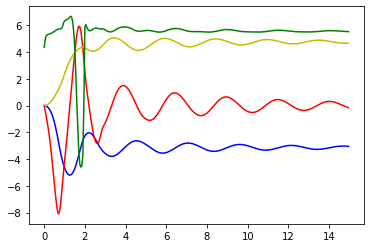

32 tensor(1206.2628, grad_fn=<SumBackward0>)


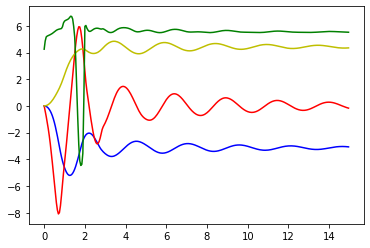

33 tensor(1197.1562, grad_fn=<SumBackward0>)


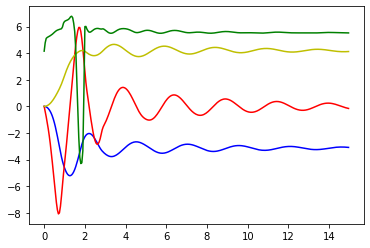

34 tensor(1188.5389, grad_fn=<SumBackward0>)


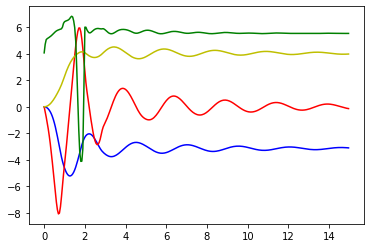

35 tensor(1180.6260, grad_fn=<SumBackward0>)


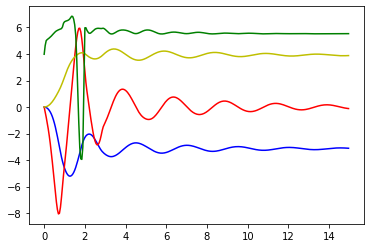

36 tensor(1173.5132, grad_fn=<SumBackward0>)


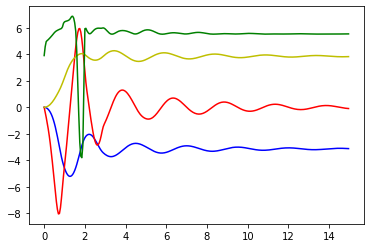

37 tensor(1167.1901, grad_fn=<SumBackward0>)


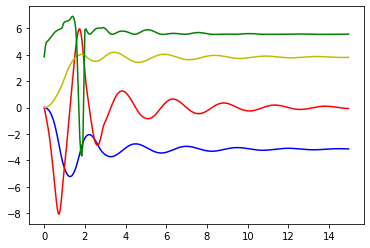

38 tensor(1161.5718, grad_fn=<SumBackward0>)


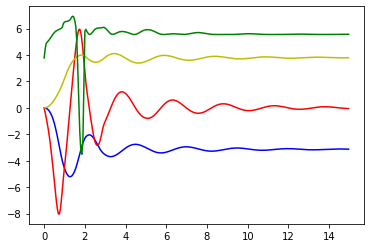

39 tensor(1156.5341, grad_fn=<SumBackward0>)


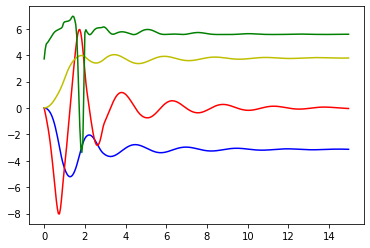

40 tensor(1151.9387, grad_fn=<SumBackward0>)


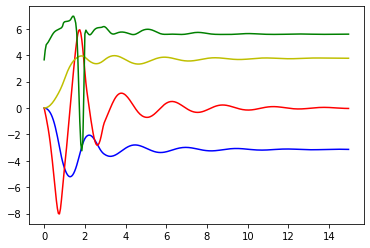

41 tensor(1147.6511, grad_fn=<SumBackward0>)


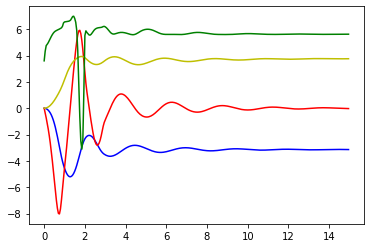

42 tensor(1143.5529, grad_fn=<SumBackward0>)


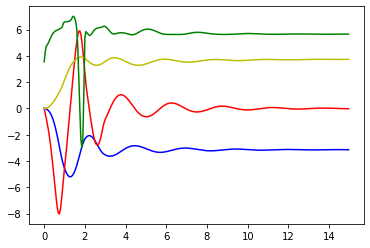

43 tensor(1139.5500, grad_fn=<SumBackward0>)


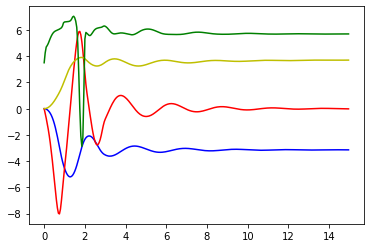

44 tensor(1135.5784, grad_fn=<SumBackward0>)


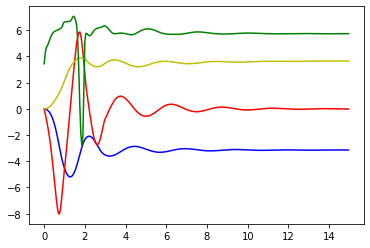

45 tensor(1131.5988, grad_fn=<SumBackward0>)


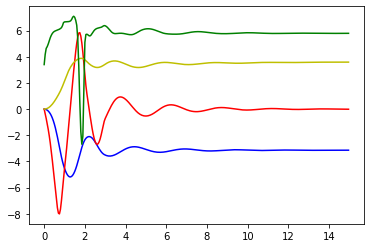

46 tensor(1127.5905, grad_fn=<SumBackward0>)


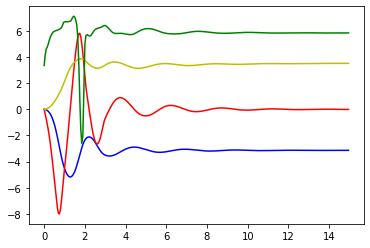

47 tensor(1123.5398, grad_fn=<SumBackward0>)


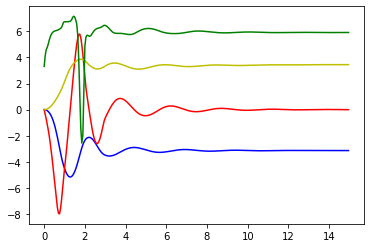

48 tensor(1119.4410, grad_fn=<SumBackward0>)


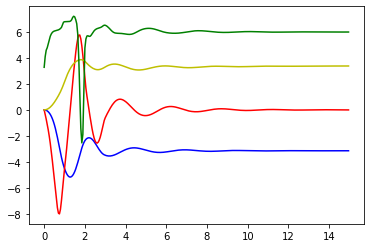

49 tensor(1115.3124, grad_fn=<SumBackward0>)


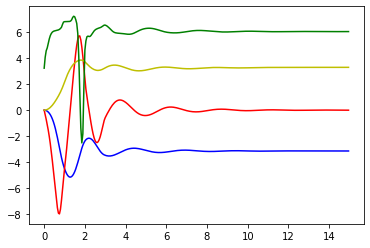

50 tensor(1111.2257, grad_fn=<SumBackward0>)


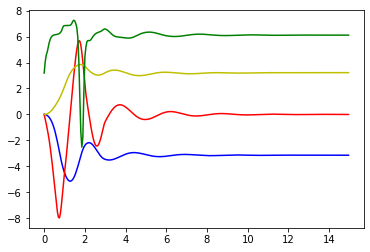

51 tensor(1107.3032, grad_fn=<SumBackward0>)


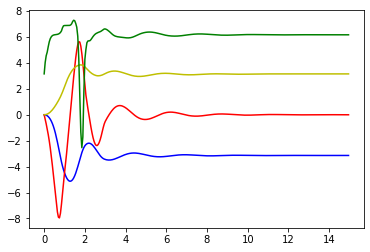

52 tensor(1103.6670, grad_fn=<SumBackward0>)


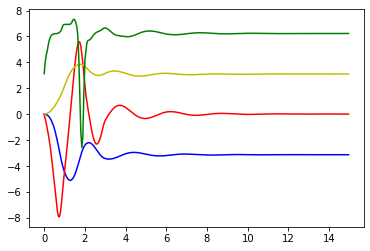

53 tensor(1100.3624, grad_fn=<SumBackward0>)


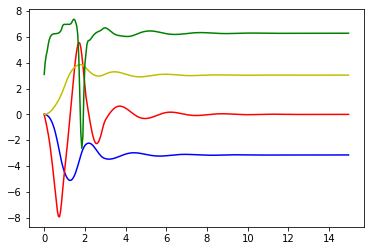

54 tensor(1097.3337, grad_fn=<SumBackward0>)


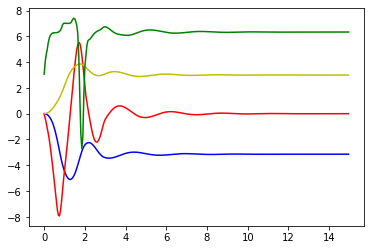

55 tensor(1094.4591, grad_fn=<SumBackward0>)


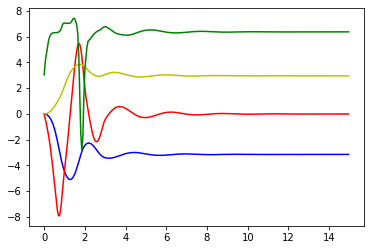

56 tensor(1091.6075, grad_fn=<SumBackward0>)


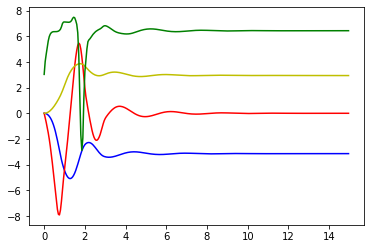

57 tensor(1088.6808, grad_fn=<SumBackward0>)


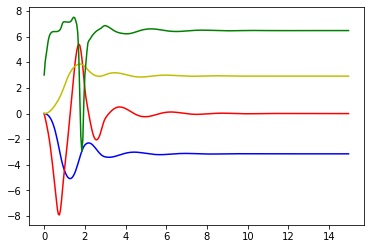

58 tensor(1085.6245, grad_fn=<SumBackward0>)


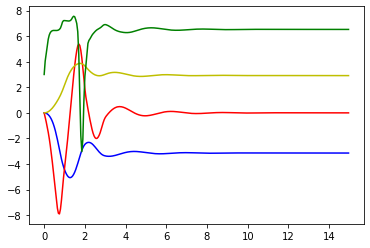

59 tensor(1082.4270, grad_fn=<SumBackward0>)


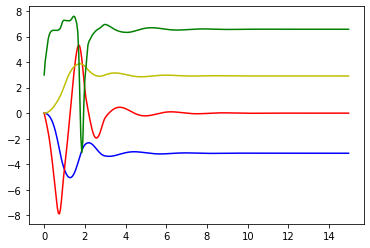

60 tensor(1079.1036, grad_fn=<SumBackward0>)


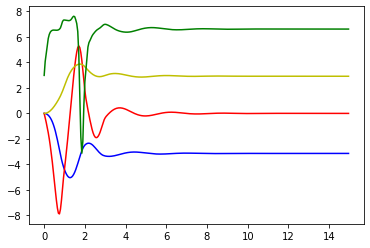

61 tensor(1075.6866, grad_fn=<SumBackward0>)


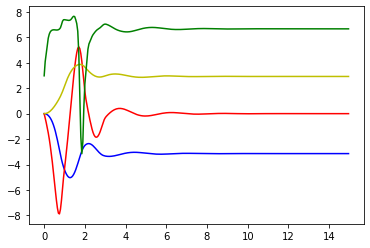

62 tensor(1072.2134, grad_fn=<SumBackward0>)


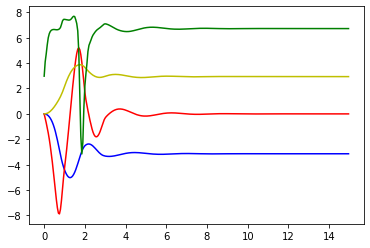

63 tensor(1068.7213, grad_fn=<SumBackward0>)


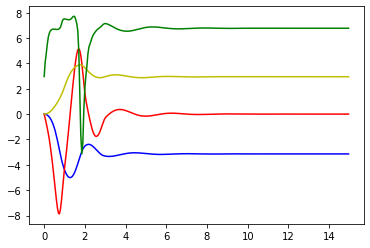

64 tensor(1065.2402, grad_fn=<SumBackward0>)


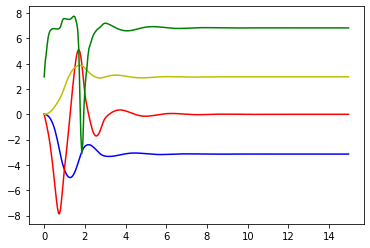

65 tensor(1061.7952, grad_fn=<SumBackward0>)


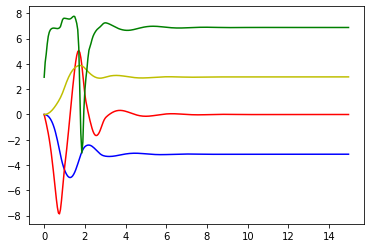

66 tensor(1058.4150, grad_fn=<SumBackward0>)


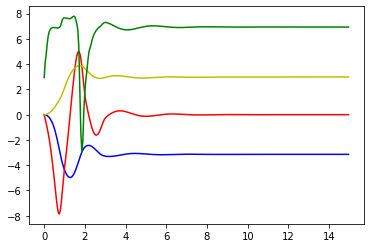

67 tensor(1055.1342, grad_fn=<SumBackward0>)


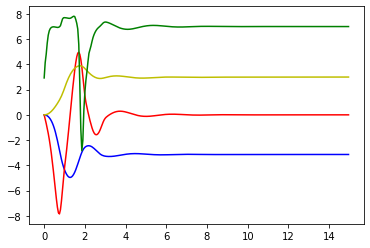

68 tensor(1051.9916, grad_fn=<SumBackward0>)


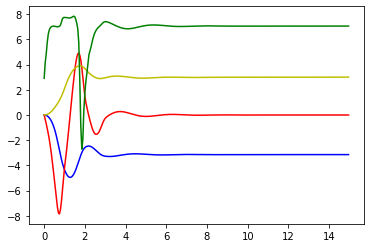

69 tensor(1049.0135, grad_fn=<SumBackward0>)


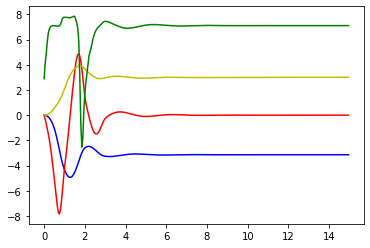

70 tensor(1046.2029, grad_fn=<SumBackward0>)


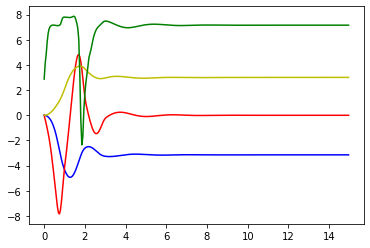

71 tensor(1043.5336, grad_fn=<SumBackward0>)


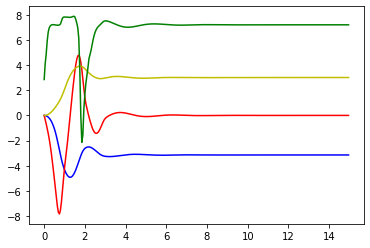

72 tensor(1040.9592, grad_fn=<SumBackward0>)


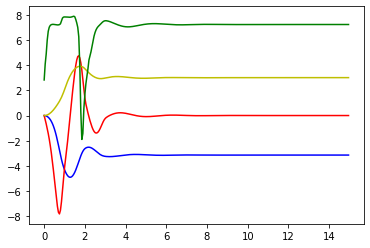

73 tensor(1038.4175, grad_fn=<SumBackward0>)


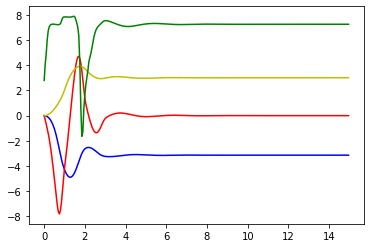

74 tensor(1035.8375, grad_fn=<SumBackward0>)


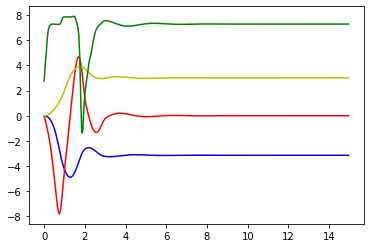

75 tensor(1033.1398, grad_fn=<SumBackward0>)


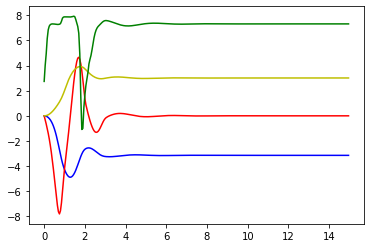

76 tensor(1030.2378, grad_fn=<SumBackward0>)


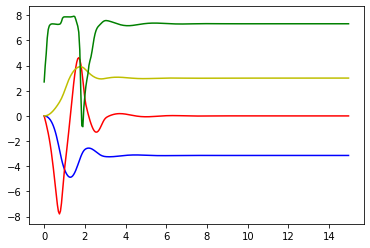

77 tensor(1027.0371, grad_fn=<SumBackward0>)


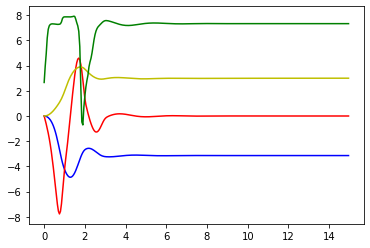

78 tensor(1023.4351, grad_fn=<SumBackward0>)


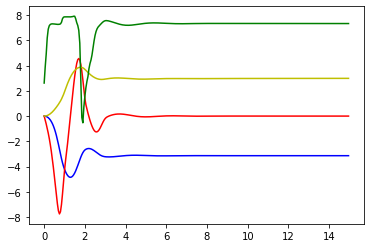

79 tensor(1019.3185, grad_fn=<SumBackward0>)


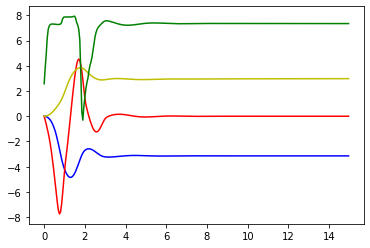

80 tensor(1014.5776, grad_fn=<SumBackward0>)


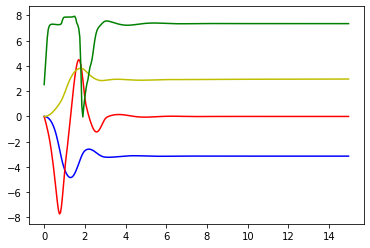

81 tensor(1009.1229, grad_fn=<SumBackward0>)


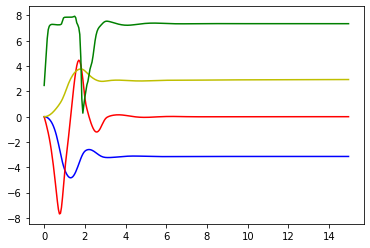

82 tensor(1002.9020, grad_fn=<SumBackward0>)


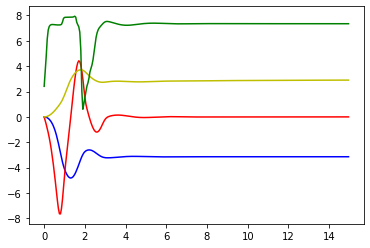

83 tensor(996.0382, grad_fn=<SumBackward0>)


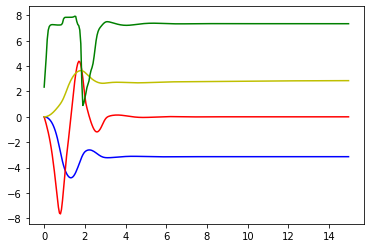

84 tensor(988.9237, grad_fn=<SumBackward0>)


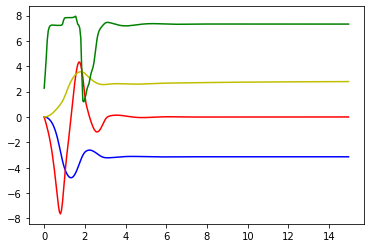

85 tensor(981.9654, grad_fn=<SumBackward0>)


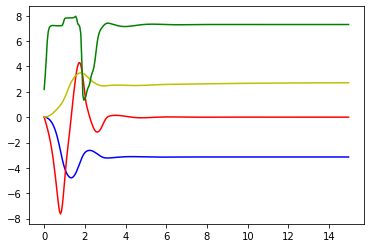

86 tensor(975.3874, grad_fn=<SumBackward0>)


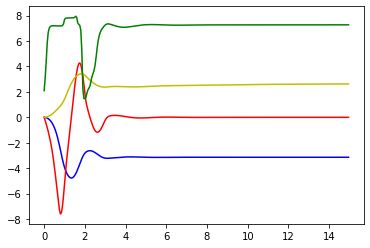

87 tensor(969.2044, grad_fn=<SumBackward0>)


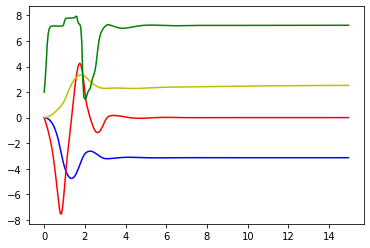

88 tensor(963.2939, grad_fn=<SumBackward0>)


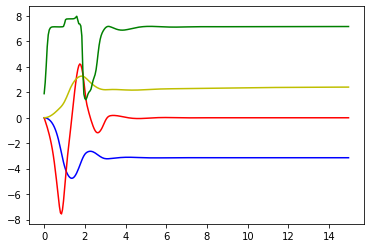

89 tensor(957.3687, grad_fn=<SumBackward0>)


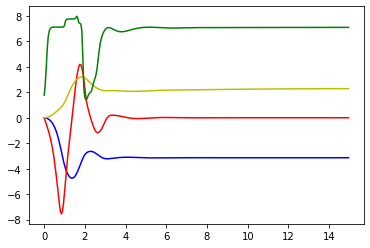

90 tensor(951.2463, grad_fn=<SumBackward0>)


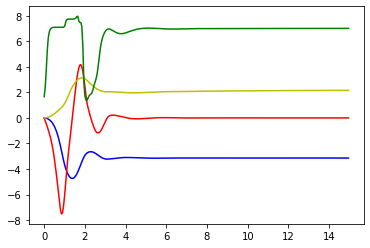

91 tensor(944.9169, grad_fn=<SumBackward0>)


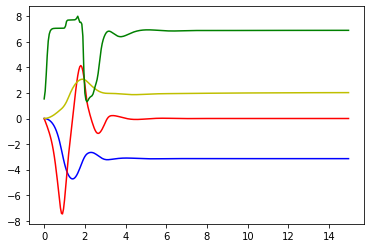

92 tensor(938.2066, grad_fn=<SumBackward0>)


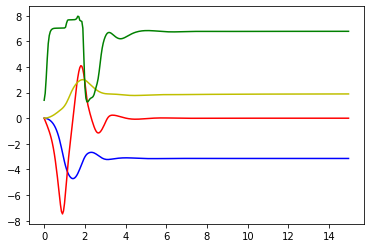

93 tensor(931.1362, grad_fn=<SumBackward0>)


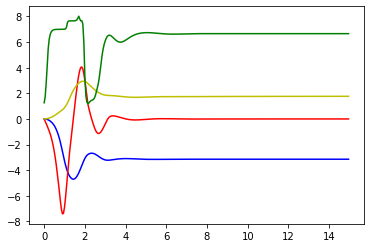

94 tensor(923.7280, grad_fn=<SumBackward0>)


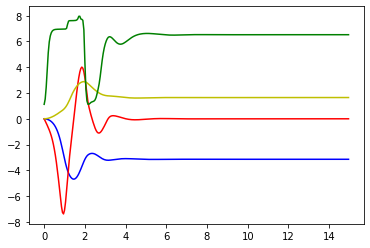

95 tensor(916.0496, grad_fn=<SumBackward0>)


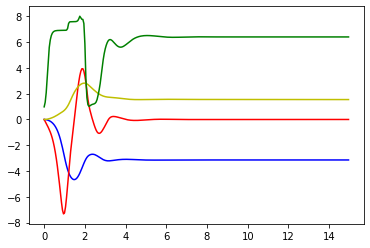

96 tensor(908.1372, grad_fn=<SumBackward0>)


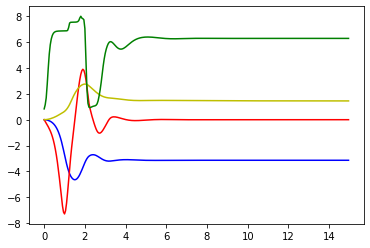

97 tensor(900.1276, grad_fn=<SumBackward0>)


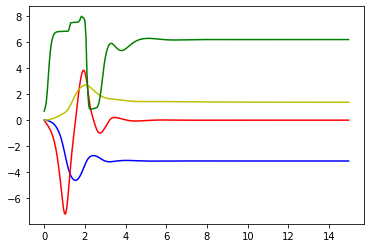

98 tensor(892.0286, grad_fn=<SumBackward0>)


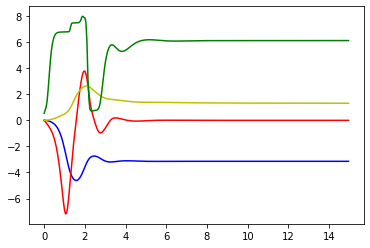

99 tensor(883.9127, grad_fn=<SumBackward0>)


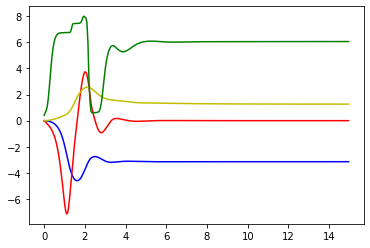

100 tensor(875.7260, grad_fn=<SumBackward0>)


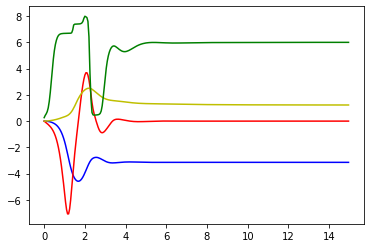

101 tensor(867.3088, grad_fn=<SumBackward0>)


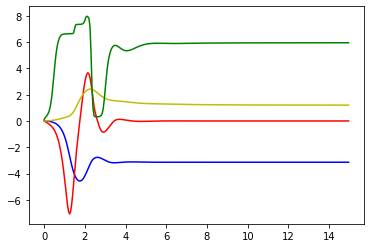

102 tensor(858.1857, grad_fn=<SumBackward0>)


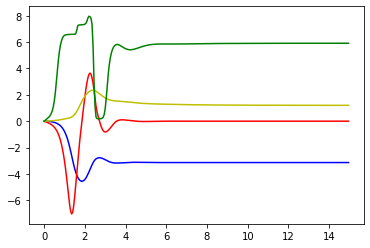

103 tensor(846.5896, grad_fn=<SumBackward0>)


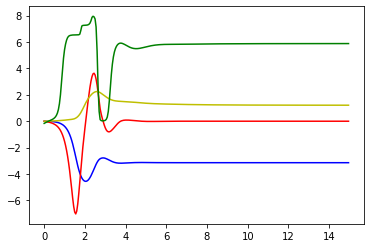

104 tensor(896.4895, grad_fn=<SumBackward0>)


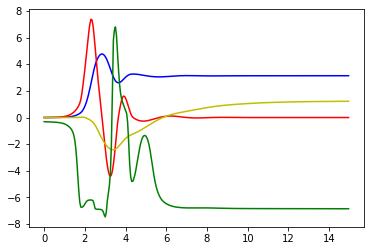

105 tensor(854.1814, grad_fn=<SumBackward0>)


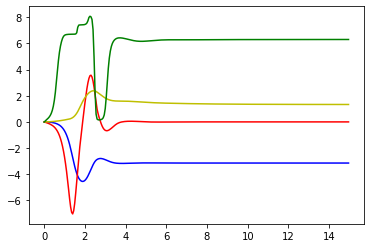

106 tensor(867.2114, grad_fn=<SumBackward0>)


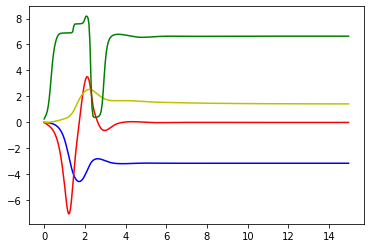

107 tensor(877.4438, grad_fn=<SumBackward0>)


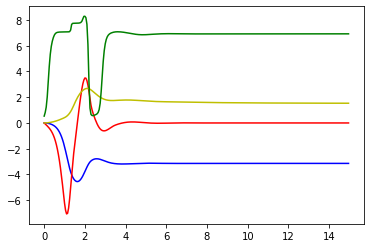

KeyboardInterrupt: 

In [12]:
init_state = torch.tensor([0, 0, 0, 0]).reshape(1, -1).float()
dt = 0.05
steps = 300
num_epoch = 10000

target = torch.cat([torch.ones(steps, 1) * np.pi, torch.ones(steps, 1) * -np.pi], dim=1)

for epoch in range(num_epoch):
    optimizer.zero_grad()
    
    # Generate Trajectory
    # init_states = torch.cat([(torch.rand(127, 2) - 0.5) * 4, init_state], dim=0)
    init_states = init_state
    t_span = torch.linspace(0, dt * (steps-1), steps)
    traj = cartpoleODE.trajectory(init_states, t_span)
    dummy = torch.cat([torch.cos(traj[:, 0, 0:1]), torch.sin(traj[:, 0, 0:1]), traj[:, 0, 1:]], dim=1)
    actions = cartpoleODE.defunc.m.policy(dummy)
    
    loss = total_cost(traj, actions)
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 1 == 0:
        print(epoch, loss)
        plt.plot(t_span.detach().numpy(), traj[:, 0, 2].detach().numpy(), 'b-')  # theta
        plt.plot(t_span.detach().numpy(), traj[:, 0, 3].detach().numpy(), 'r-')  # theta_dot
        plt.plot(t_span.detach().numpy(), traj[:, 0, 0].detach().numpy(), 'y-')  # x-pos
        plt.plot(t_span.detach().numpy(), actions.detach().numpy(), 'g-')
        # plt.ylim(-4, 4)
        plt.show()
print('Finished Training')

In [ ]:
pendulumODE.eval()
None

In [ ]:
init_state = torch.tensor([0, 0]).reshape(1, -1).float()
t_span = torch.linspace(0, 5, 100)
traj = pendulumODE.trajectory(init_state, t_span)
# dummy = torch.stack([torch.cos(traj[:, 0, 0]), torch.sin(traj[:, 0, 0]), traj[:, 0, 1]], dim=1)
# actions = pendulumODE.defunc.m.policy(dummy)
actions = pendulumODE.defunc.m.policy(traj)
print(traj.shape)
print(actions.shape)

In [ ]:
plt.plot(t_span.detach().numpy(), traj[:, 0, 0:2].detach().numpy())
plt.plot(t_span.detach().numpy(), actions.detach().numpy())

## Conclusion